## Jialin Shi  --  Frog Species Identification

### Multi-class and Multi-Label Classification
###### Method 1:
Train a SVM(and L1-penalized SVM) for each of the labels, using Gaussian kernels and one versus all classifiers.         
Determine the weight of the SVM penalty and the width of the Gaussian Kernel using 10 fold cross validation.       
Use SMOTE to remedy class imbalance.

###### Method 2:
Implement K-means clustering to cluster data.    
Choose best k based on highest Silhouettes.    
In each cluster, determine the majority class for each label.    
Calculate hamming score and exact match.   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

from sklearn.model_selection import train_test_split  # split data for training and testing
from sklearn.preprocessing import StandardScaler      # standardScaler,uniformed
from sklearn.metrics import confusion_matrix                         
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import calinski_harabaz_score
from sklearn.metrics import hamming_loss
import warnings
warnings.filterwarnings('ignore')


#### (a)

In [2]:
# (a)load data 
df = pd.read_csv('Frogs_MFCCs.csv',header=0)

#split data into train and test
train,test=train_test_split(df,test_size=0.3,random_state=42)

#mark for x and y.
train_x=train.iloc[:,0:-4]
test_x=test.iloc[:,0:-4]

train_family=train.iloc[:,-4]
test_family=test.iloc[:,-4]

train_genus=train.iloc[:,-3]
test_genus=test.iloc[:,-3]

train_species=train.iloc[:,-2]
test_species=test.iloc[:,-2]


#### Research exact match and hamming loss methods for evaluating multi- label classification.

Multi-label classification methods needs different measurements
than used in traditional single-label classification. 

Accuracy score/ Exact match metric: this function calculates subset accuracy meaning the predicted set of labels should exactly match with the true set of labels.

Hamming Loss: the fraction of the wrong labels to the total number of labels.

#### SVC

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'decision_function_shape':['ovr'],
                     'gamma': [1e1,1e0,1e-1,1e-2,1e-3,1e-4],
                     'C': [1, 10, 100, 1000,10000,100000]}]

clf1 = GridSearchCV(SVC(), tuned_parameters, cv=10)
clf1.fit(train_x, train_family)
print("Best parameters set for clf1:")
print(clf1.best_params_)

clf2 = GridSearchCV(SVC(), tuned_parameters, cv=10)
clf2.fit(train_x, train_genus)
print("Best parameters set for clf2:")
print(clf2.best_params_)

clf3 = GridSearchCV(SVC(), tuned_parameters, cv=10)
clf3.fit(train_x, train_species)
print("Best parameters set for clf3:")
print(clf3.best_params_)


Best parameters set for clf1:
{'C': 100, 'decision_function_shape': 'ovr', 'gamma': 1.0, 'kernel': 'rbf'}
Best parameters set for clf2:
{'C': 100, 'decision_function_shape': 'ovr', 'gamma': 1.0, 'kernel': 'rbf'}
Best parameters set for clf3:
{'C': 10, 'decision_function_shape': 'ovr', 'gamma': 1.0, 'kernel': 'rbf'}


In [4]:
# use best params to build classifier
# family classifier
clf1 =SVC(C=100,decision_function_shape='ovr',gamma=1,kernel='rbf')
clf1.fit(train_x, train_family)
pred=clf1.predict(test_x)
print(hamming_loss(test_family, pred))
pred3=pd.DataFrame(pred)

# genus classifier
clf2 =SVC(C=100,decision_function_shape='ovr',gamma=1,kernel='rbf')
clf2.fit(train_x, train_genus)
pred=clf2.predict(test_x)
print(hamming_loss(test_genus, pred))
pred=pd.DataFrame(pred)
pred3=pd.concat([pred3,pred],axis=1)

# species classifier
clf3 =SVC(C=10,decision_function_shape='ovr',gamma=1,kernel='rbf')
clf3.fit(train_x, train_species)
pred=clf3.predict(test_x)
print(hamming_loss(test_species, pred))
pred=pd.DataFrame(pred)
pred3=pd.concat([pred3,pred],axis=1)

# exact match
true_label=df.iloc[:,-4:-1]
same=0
for i in range(len(pred3)):
    a=pred3.iloc[i,:].values
    b=true_label.iloc[i,:].values
    if a[0]+a[1]+a[2]==b[0]+b[1]+b[2]:
        same=same+1
print(same/len(pred3))        

0.006484483557202408
0.007874015748031496
0.010653080129689671
0.25104214914312184


#### SVC model Hamming Loss for test:   
family:0.006484483557202408    
genuse:0.007874015748031496    
species:0.010653080129689671

Exact match=0.25

#### L1-penalized SVM

In [5]:
from sklearn.svm import LinearSVC

# Set the parameters by cross-validation
tuned_parameters = [{'tol': [1e1,1e0,1e-1,1e-2,1e-3,1e-4],
                     'C': [1, 10, 100, 1000,10000,100000]}]

#build model
LSVC=LinearSVC(penalty='l1',dual=False)

clf1 = GridSearchCV(LSVC, tuned_parameters, cv=10)
clf1.fit(train_x, train_family)
print("Best parameters set for clf1:")
print(clf1.best_params_)

clf2 = GridSearchCV(LSVC, tuned_parameters, cv=10)
clf2.fit(train_x, train_genus)
print("Best parameters set for clf2:")
print(clf2.best_params_)

clf3 = GridSearchCV(LSVC, tuned_parameters, cv=10)
clf3.fit(train_x, train_species)
print("Best parameters set for clf3:")
print(clf3.best_params_)

Best parameters set for clf1:
{'C': 100, 'tol': 0.0001}
Best parameters set for clf2:
{'C': 10000, 'tol': 0.01}
Best parameters set for clf3:
{'C': 100, 'tol': 0.01}


Best parameters set for clf1:
{'C': 100, 'tol': 0.0001}

Best parameters set for clf2:
{'C': 100, 'tol': 0.001}

Best parameters set for clf3:
{'C': 10, 'tol': 0.001}

In [6]:
# family classifier
clf1 =LinearSVC(penalty='l1',dual=False,C=100,tol=0.0001)
clf1.fit(train_x, train_family)
pred=clf1.predict(test_x)
print(hamming_loss(test_family, pred))
predL3=pd.DataFrame(pred)

# genus classifier
clf2 =LinearSVC(penalty='l1',dual=False,C=100,tol=0.001)
clf2.fit(train_x, train_genus)
pred=clf2.predict(test_x)
print(hamming_loss(test_genus, pred))
pred=pd.DataFrame(pred)
predL3=pd.concat([predL3,pred],axis=1)

# species classifier
clf3 =LinearSVC(penalty='l1',dual=False,C=10,tol=0.001)
clf3.fit(train_x, train_species)
pred=clf3.predict(test_x)
print(hamming_loss(test_species, pred))
pred=pd.DataFrame(pred)
predL3=pd.concat([predL3,pred],axis=1)

# exact match
true_label=df.iloc[:,-4:-1]
same=0
for i in range(len(predL3)):
    a=predL3.iloc[i,:].values
    b=true_label.iloc[i,:].values
    if a[0]+a[1]+a[2]==b[0]+b[1]+b[2]:
        same=same+1
print(same/len(predL3))

0.07364520611394164
0.05974988420565076
0.04029643353404354
0.24965261695229274


#### LinearSVC model Hamming Loss for test:   
family:0.07364520611394164    
genuse:0.059286706808707734    
species:0.03890690134321445  

Exact match: 0.249

#### SMOTE

###### family_sp

In [7]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_x, train_family)
#build model
LSVC=LinearSVC(penalty='l1',dual=False)
sp1 = GridSearchCV(LSVC, tuned_parameters, cv=10)
sp1.fit(X_res, y_res)
print("Best parameters set for sp1:")
print(sp1.best_params_)

Best parameters set for sp1:
{'C': 10, 'tol': 0.0001}


Best parameters set for sp1: {'C': 100000, 'tol': 0.001}

In [8]:
# new sp family classifier
sp1 =LinearSVC(penalty='l1',dual=False,C=100000,tol=0.001)
sp1.fit(X_res, y_res)
pred=sp1.predict(test_x)
print("new sp hamming loss:",hamming_loss(test_family, pred))
predL3=pd.DataFrame(pred)

new sp hamming loss: 0.09078276980083372


###### genus-sp

In [9]:
sm = SMOTE(random_state=42)
X_genus, y_genus = sm.fit_resample(train_x, train_genus)
#build model
LSVC=LinearSVC(penalty='l1',dual=False)
sp2 = GridSearchCV(LSVC, tuned_parameters, cv=10)
sp2.fit(X_genus, y_genus)
print("Best parameters set for sp2:")
print(sp2.best_params_)

Best parameters set for sp2:
{'C': 1000, 'tol': 0.001}


Best parameters set for sp2: {'C': 1000, 'tol': 0.001}

In [10]:
# new sp genus classifier
sp2 =LinearSVC(penalty='l1',dual=False,C=1000,tol=0.001)
sp2.fit(X_genus, y_genus)
pred=sp2.predict(test_x)
print("new sp hamming loss:",hamming_loss(test_genus, pred))
predL3=pd.DataFrame(pred)

new sp hamming loss: 0.0935618341824919


###### species-sp

In [11]:
sm = SMOTE(random_state=42)
X_species, y_species = sm.fit_resample(train_x, train_species)
#build model
LSVC=LinearSVC(penalty='l1',dual=False)
sp3 = GridSearchCV(LSVC, tuned_parameters, cv=10)
sp3.fit(X_species, y_species)
print("Best parameters set for sp3:")
print(sp3.best_params_)

Best parameters set for sp3:
{'C': 100, 'tol': 0.001}


Best parameters set for sp3: {'C': 1000, 'tol': 0.001}

In [12]:
# new sp species classifier
sp3 =LinearSVC(penalty='l1',dual=False,C=1000,tol=0.001)
sp3.fit(X_species, y_species)
pred=sp3.predict(test_x)
print("new sp3 hamming loss:",hamming_loss(test_species, pred))
predL3=pd.DataFrame(pred)

new sp3 hamming loss: 0.03890690134321445


#### After resampling (downsample to same size to solve imbalance)
new best parameters for linearSVC

Best parameters set for sp1: {'C': 100000, 'tol': 0.001}    
Best parameters set for sp2: {'C': 1000, 'tol': 0.001}     
Best parameters set for sp3: {'C': 1000, 'tol': 0.001}

#### Conclusion:

To solve the imbalance problem I used SMoTE to make each class with equal size. However, it has the risk that increasing too many support vectors which leads to a narrower margin. Therefore more variance in test set(increase hamming loss)  

If support vectors are slightly increased, then the model may perform better for better bias and reasonable variance.



#### (2) Clustering

4 0.3839129000392388


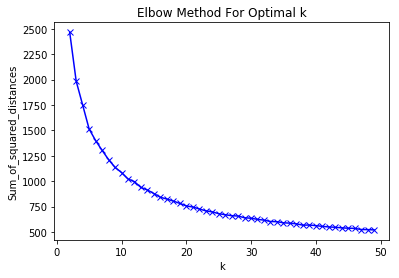

In [13]:
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import calinski_harabaz_score

# split x and y
df = pd.read_csv('Frogs_MFCCs.csv',header=0)
X=df.iloc[:,0:-4]
Y_family=df.iloc[:,-4]
Y_genus=df.iloc[:,-3]
Y_species=df.iloc[:,-2]


Sum_of_squared_distances = []
K = range(2,50)
scoremax=0
bestk=0
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    labels = km.labels_
    Sum_of_squared_distances.append(km.inertia_)
    score=silhouette_score(X, labels, metric='euclidean',random_state=1)
    if score>scoremax:
        scoremax=score
        bestk=k
print(bestk,scoremax)                            
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


#### Best k = 4, with the highest score of 0.37886255335886554

#### Find majority class

In [14]:
km = KMeans(n_clusters=4,random_state=1)
km = km.fit(X)
label=km.labels_
df_family=df.iloc[:,-4]
df_genus=df.iloc[:,-3]
df_species=df.iloc[:,-2]

In [15]:
# for y_family
df_new=pd.DataFrame([df_family.values,label,np.ones(len(label))],index=['Name','Class','Count']).T
majority=df_new.groupby(['Class','Name']).count()
majority

Count
Class Name                  
0     Bufonidae            2
      Hylidae            590
      Leptodactylidae     22
1     Dendrobatidae      500
      Hylidae            229
      Leptodactylidae    302
2     Hylidae            101
      Leptodactylidae   3467
3     Bufonidae           66
      Dendrobatidae       42
      Hylidae           1245
      Leptodactylidae    629

In [16]:
a=majority.reset_index()
for i in np.unique(a['Class']):
    idm=a[a['Class']==i]['Count'].idxmax()
    Name=a['Name'].iloc[idm]
    df_new.loc[df_new['Class']==i,'Name']=Name
    print(Name)
pred_label=pd.DataFrame(df_new.iloc[:,0])

Hylidae
Dendrobatidae
Leptodactylidae
Hylidae


For Family:

'Class'=0,'Hylidae'    
'Class'=1,'Dendrobatidae'    
'Class'=2,'Leptodactylidae'   
'Class'=3,'Hylidae'   

In [17]:
# for y_genuse
df_new=pd.DataFrame([df_genus.values,label,np.ones(len(label))],index=['Name','Class','Count']).T
majority2=df_new.groupby(['Class','Name']).count()
majority2

Count
Class Name                
0     Adenomera         12
      Hypsiboas        542
      Leptodactylus     10
      Osteocephalus     38
      Rhinella           2
      Scinax            10
1     Adenomera        296
      Ameerega         500
      Dendropsophus    189
      Hypsiboas          1
      Leptodactylus      6
      Scinax            39
2     Adenomera       3466
      Dendropsophus     86
      Hypsiboas         12
      Leptodactylus      1
      Scinax             3
3     Adenomera        376
      Ameerega          42
      Dendropsophus     35
      Hypsiboas       1038
      Leptodactylus    253
      Osteocephalus     76
      Rhinella          66
      Scinax            96

In [18]:
a=majority2.reset_index()
for i in np.unique(a['Class']):
    idm=a[a['Class']==i]['Count'].idxmax()
    Name=a['Name'].iloc[idm]
    df_new.loc[df_new['Class']==i,'Name']=Name
#    print(Name)
pred_label=pd.concat([pred_label,df_new.iloc[:,0]],axis=1)

For Genus:
    
'Class'=0,'Hypsiboas'    
'Class'=1,'Ameerega'    
'Class'=2,'Adenomera'    
'Class'=3,'Hypsiboas'

In [19]:
# for y_species
df_new=pd.DataFrame([df_species.values,label,np.ones(len(label))],index=['Name','Class','Count']).T
majority3=df_new.groupby(['Class','Name']).count()
majority3

Count
Class Name                         
0     AdenomeraAndre              6
      AdenomeraHylaedactylus      6
      HypsiboasCinerascens      452
      HypsiboasCordobae          90
      LeptodactylusFuscus        10
      OsteocephalusOophagus      38
      Rhinellagranulosa           2
      ScinaxRuber                10
1     AdenomeraAndre            296
      Ameeregatrivittata        500
      HylaMinuta                189
      HypsiboasCordobae           1
      LeptodactylusFuscus         6
      ScinaxRuber                39
2     AdenomeraHylaedactylus   3466
      HylaMinuta                 86
      HypsiboasCordobae          12
      LeptodactylusFuscus         1
      ScinaxRuber                 3
3     AdenomeraAndre            370
      AdenomeraHylaedactylus      6
      Ameeregatrivittata         42
      HylaMinuta                 35
      HypsiboasCinerascens       20
      HypsiboasCordobae        1018
      LeptodactylusFuscus       253
      OsteocephalusOophagus      76
      Rhinellagranulosa          66
      ScinaxRuber                96

In [20]:
a=majority3.reset_index()
for i in np.unique(a['Class']):
    idm=a[a['Class']==i]['Count'].idxmax()
    Name=a['Name'].iloc[idm]
    df_new.loc[df_new['Class']==i,'Name']=Name
    print(Name)
pred_label=pd.concat([pred_label,df_new.iloc[:,0]],axis=1)

HypsiboasCinerascens
Ameeregatrivittata
AdenomeraHylaedactylus
HypsiboasCordobae


#### Calculate hamming loss

In [21]:
# prepare true_label and predict_label
true_label=df.iloc[:,-4:-1]
pred_label.columns=['Family','Genus','Species']

In [22]:
# calculate hamming loss
y_pred=pred_label.values.ravel().tolist()
y_true=true_label.values.ravel().tolist()
from sklearn.metrics import hamming_loss
hamming_loss(y_true, y_pred)

0.2224229789205467

In [23]:
# hamming score /accuracy score
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.7775770210794534

In [24]:
# hamming distance
dis=0
result = zip(y_pred, y_true)
for i in result:
    if i[0]!=i[1]:
        dis=dis+1
print(dis/3)    

1600.3333333333333


#### EVALUATE
Hamming loss:0.2224229789205467    
Hamming Score:0.7775770210794534    
AVG Hamming Distance: 4801/3=1600.33 

#### monte carlo

In [25]:
# split x and y
df = pd.read_csv('Frogs_MFCCs.csv',header=0)
X=df.iloc[:,0:-4]
df_family=df.iloc[:,-4]
df_genus=df.iloc[:,-3]
df_species=df.iloc[:,-2]
dist=[]
 
for i in range(50):
    K = range(2,50)
    scoremax=0
    bestk=0
    for k in K:
        km = KMeans(n_clusters=k)
        km = km.fit(X)
        labels = km.labels_
        score=silhouette_score(X, labels, metric='euclidean',random_state=1)
        if score>scoremax:
            scoremax=score
            bestk=k
    print(i,bestk)
    km = KMeans(n_clusters=bestk)
    km = km.fit(X)
    label=km.labels_

    # for y_family
    df_new=pd.DataFrame([df_family.values,label,np.ones(len(label))],index=['Name','Class','Count']).T
    majority=df_new.groupby(['Class','Name']).count()
    a=majority.reset_index()
    for i in np.unique(a['Class']):
        idm=a[a['Class']==i]['Count'].idxmax()
        Name=a['Name'].iloc[idm]
        df_new.loc[df_new['Class']==i,'Name']=Name
    pred_label=pd.DataFrame(df_new.iloc[:,0])
    
    # for y_genuse
    df_new=pd.DataFrame([df_genus.values,label,np.ones(len(label))],index=['Name','Class','Count']).T
    majority2=df_new.groupby(['Class','Name']).count()
    a=majority2.reset_index()
    for i in np.unique(a['Class']):
        idm=a[a['Class']==i]['Count'].idxmax()
        Name=a['Name'].iloc[idm]
        df_new.loc[df_new['Class']==i,'Name']=Name
    pred_label=pd.concat([pred_label,df_new.iloc[:,0]],axis=1)
    
    # for y_species
    df_new=pd.DataFrame([df_species.values,label,np.ones(len(label))],index=['Name','Class','Count']).T
    majority3=df_new.groupby(['Class','Name']).count()
    a=majority3.reset_index()
    for i in np.unique(a['Class']):
        idm=a[a['Class']==i]['Count'].idxmax()
        Name=a['Name'].iloc[idm]
        df_new.loc[df_new['Class']==i,'Name']=Name
    pred_label=pd.concat([pred_label,df_new.iloc[:,0]],axis=1)
    
    # prepare true_label and predict_label
    true_label=df.iloc[:,-4:-1]
    pred_label.columns=['Family','Genus','Species']
    y_pred=pred_label.values.ravel().tolist()
    y_true=true_label.values.ravel().tolist()
    
    # hamming distance
    dis=0
    result = zip(y_pred, y_true)
    for i in result:
        if i[0]!=i[1]:
            dis=dis+1
    dis=dis/3
    print("AVG hamming distance:",dis)
    dist.append(dis)  
      

0 4
AVG hamming distance: 1600.3333333333333
1 4
AVG hamming distance: 1600.3333333333333
2 4
AVG hamming distance: 1600.3333333333333
3 4
AVG hamming distance: 1599.3333333333333
4 4
AVG hamming distance: 1600.3333333333333
5 4
AVG hamming distance: 1600.3333333333333
6 4
AVG hamming distance: 1600.3333333333333
7 4
AVG hamming distance: 1600.6666666666667
8 4
AVG hamming distance: 1600.3333333333333
9 4
AVG hamming distance: 1600.3333333333333
10 4
AVG hamming distance: 1600.3333333333333
11 4
AVG hamming distance: 1600.3333333333333
12 4
AVG hamming distance: 1600.3333333333333
13 4
AVG hamming distance: 1600.3333333333333
14 4
AVG hamming distance: 1600.3333333333333
15 4
AVG hamming distance: 1764.6666666666667
16 4
AVG hamming distance: 1600.3333333333333
17 4
AVG hamming distance: 1600.3333333333333
18 4
AVG hamming distance: 1600.3333333333333
19 4
AVG hamming distance: 1600.3333333333333
20 4
AVG hamming distance: 1764.6666666666667
21 4
AVG hamming distance: 1596.666666666666

In [26]:
np.mean(dist)

1610.033333333333

In [27]:
np.std(dist)

35.358623024974044

Monte Carlo(50 times)
mean: 1618.16
std:47.18